In [998]:
import glob
import os
import pickle
import sys
from pathlib import Path
import random
from tqdm import tqdm

import torchvision.models as models
from torch.nn import Module, Dropout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
import torchvision

#from pytorchtools import EarlyStopping

from sklearn.metrics import mean_squared_error
import pandas as pd

from torchvision import datasets, models, transforms
import time
import logging

#from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import KFold
#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV



In [3]:
train_transforms = transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.RandomVerticalFlip(),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(brightness=0, contrast=0, saturation=1, hue=.5),
                                    transforms.ToTensor()])


val_transforms= transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.ToTensor()])



# cross validaion with 5 folders on the train 
train_dataset = datasets.ImageFolder('/Users/eudari01/GNNs_Vs_CNNs/tiles_CIN/train/', train_transforms) 

# cross validaion with 5 folders on the val 
val_dataset = datasets.ImageFolder('/Users/eudari01/GNNs_Vs_CNNs/tiles_CIN/val/', val_transforms) 


batch_size = 48
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)
valid_loader= torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=16, shuffle=True)

                         

In [5]:
#chesk the classes 
#train_dataset.classes


In [6]:
#model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn', pretrained=True)

In [7]:
#model.eval()

In [4]:
class VGG_19_Regression(Module):
    
    def __init__(self,):
        
        model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn', pretrained=True)
        
        super(VGG_19_Regression,self).__init__()
        self.model= model
        self.Regression = nn.Linear(1000,1)
        self.dropout = Dropout(0.5)
        
           
         
    def forward(self, out):
        
        x= self.model(out)
        
        x = x.view(x.size(0), -1) # flatten
        
        x = self.dropout(x)
        
        x =self.Regression(x)
        
        return x

In [9]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Model = models.vgg19(pretrained=True).features.to(device).eval()

In [5]:
Model= VGG_19_Regression()

MSE = torch.nn.MSELoss()
optimizer = torch.optim.SGD(Model.parameters(), lr=0.00001,momentum=0.9)


Using cache found in /Users/eudari01/.cache/torch/hub/pytorch_vision_v0.10.0


In [6]:
#train_accuracy=[]
train_loss = []
val_loss = []

def training(epoch):
      
    for i in range(5) : 
     
        
      
        epoch_loss = 0.0
        running_loss_train=0.0
   
        for data, label in tqdm(train_loader):
        
            label= label.to(torch.float32)
            label = label.unsqueeze(1)

         
        #Transfer Data to GPU if available
        #if torch.cuda.is_available():
            #data = data.cuda()
            #label = label.cuda()
            #Model.train()
            output = Model(data)
            #you can change the loss and use MSE or Cross Entropy
            loss = MSE(output,label)
           
            # Clear the gradients
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            
            #Calculate accuracy 
            #prediction_train=output.argmax(dim=1)
           # acc = (prediction_train== label1).float().mean()
        
            running_loss_train =+ loss.item()* data.size(0) 
            #Epoch
            #epoch_accuracy += acc.item() / len(train_loader)
            epoch_loss += running_loss_train / len(train_loader)
            
            
        Model.eval()
        epoch_val_loss = 0.0
        running_loss_val= 0.0
        
  
        
        for data, label in valid_loader:
            #if torch.cuda.is_available():
                
                #data = data.cuda()
                #label = label.cuda()
                #label= label.to(torch.float32)
                #label = label.unsqueeze(1)
    
                output = Model(data)
                
                loss = MSE(output, label)
                
                # Clear the gradients
                #optimizer.zero_grad()
                
                #val_loss.backward()
                
                #optimizer.step()
                #Calculate accuracy 
                #prediction_val= val_output.argmax(dim=1)
                
                #mse_val=mean_squared_error(label,prediction_val)
                
                #val_acc = (prediction_val == label).float().mean()
                
                running_loss_val =+ loss.item()* data.size(0) 
               
                #Epoch
                #epoch_val_accuracy += val_acc.item() / len(valid_loader)
                epoch_val_loss += running_loss_val / len(valid_loader)

                    
            
        val_loss.append(epoch_val_loss)
        train_loss.append(epoch_loss)
    #train_accuracy.append(epoch_accuracy)
        #print('Split: {}'.format(i))                
        print(
            f"Epoch : {epoch+1} - train_loss : {epoch_loss:.4f} - val_loss : {epoch_val_loss:.4f} \n")

In [7]:
epochs=5
for epoch in range(1,epochs+1):
     training(epoch)

100%|███████████████████████████████████████████| 61/61 [17:18<00:00, 17.03s/it]
/Users/eudari01/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([48])) that is different to the input size (torch.Size([48, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/eudari01/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 2 - train_loss : 198.5318 - val_loss : 104.6466 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 2 - train_loss : 104.3880 - val_loss : 101.2743 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 2 - train_loss : 102.6392 - val_loss : 93.1937 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 2 - train_loss : 100.5850 - val_loss : 95.7866 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 2 - train_loss : 99.0143 - val_loss : 94.2361 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 3 - train_loss : 98.7961 - val_loss : 104.8711 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 3 - train_loss : 98.2802 - val_loss : 91.5123 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 3 - train_loss : 97.1217 - val_loss : 93.2084 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 3 - train_loss : 96.7735 - val_loss : 91.4922 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 3 - train_loss : 97.1342 - val_loss : 91.1122 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 4 - train_loss : 97.3862 - val_loss : 93.6766 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 4 - train_loss : 97.6438 - val_loss : 91.8514 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 4 - train_loss : 96.4948 - val_loss : 90.1754 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 4 - train_loss : 97.0111 - val_loss : 91.9637 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 4 - train_loss : 95.9387 - val_loss : 91.5774 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 5 - train_loss : 96.6626 - val_loss : 92.1217 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 5 - train_loss : 96.1591 - val_loss : 92.9518 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 5 - train_loss : 96.0044 - val_loss : 90.3634 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 5 - train_loss : 96.0132 - val_loss : 91.3176 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 5 - train_loss : 95.1435 - val_loss : 89.9238 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 6 - train_loss : 95.8815 - val_loss : 89.8418 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 6 - train_loss : 97.1110 - val_loss : 90.6401 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 6 - train_loss : 96.0611 - val_loss : 91.0066 



  0%|                                                    | 0/61 [00:00<?, ?it/s]

Epoch : 6 - train_loss : 95.0228 - val_loss : 90.3243 



100%|███████████████████████████████████████████| 61/61 [16:08<00:00, 15.88s/it]


Epoch : 6 - train_loss : 96.3428 - val_loss : 91.4109 



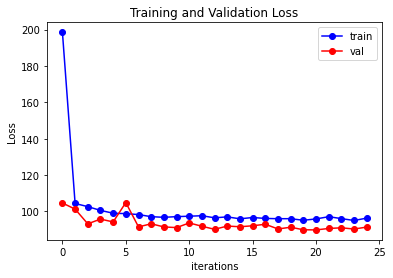

In [8]:
# to check the overfiting 
plt.title("Training and Validation Loss")
plt.plot(train_loss, 'bo-',label="train")
plt.plot(val_loss, 'ro-',label="val")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig
plt.show()

Aggregation Patient level

In [582]:
import pandas as pd

In [773]:
def prediction(path,Patient_ID):

    predict=[]
    images= os.listdir('/Users/eudari01/GNNs_Vs_CNNs/'+path) 

    for eachtiles in images:
        
        Model.eval()
        
        img = Image.open('/Users/eudari01/GNNs_Vs_CNNs/'+path+ eachtiles)
       
        #convert the image to a tensor
        convert_tensor = transforms.ToTensor()
        image = convert_tensor(img)
        # the model, prediction
        outputs=Model(image[None, ...].float())
        
        predicted = outputs.data.numpy()
        predict.append(predicted) 
        
        # save the file into a text file 
        x = np.array(predict)
        y=list(x.flatten())
        np.savetxt(Patient_ID + '.txt', y,delimiter=',')
        #df = pd.read_csv (Patient_ID +'.txt')
        #df = pd.DataFrame(df, columns = [Patient_ID ])
        
        #df.to_csv(Patient_ID +'.csv')

     
    return
        
        
        

In [765]:
#get the prediction for one split and all the tiles 
def AllIDprediction(path):
    
    allID= os.listdir('/Users/eudari01/GNNs_Vs_CNNs/'+ path)
    for ID in allID :

        prediction('/tiles_CIN/train/tiles_has_CIN_HE_trainsetCV_fold_0/'+ ID+'/train_metastasis/',ID )

In [949]:
#images= os.listdir('/Users/eudari01/GNNs_Vs_CNNs/tiles_CIN/train/tiles_has_CIN_HE_trainsetCV_fold_0/'+'')

In [1027]:
#predictionsfiles= ('/Users/eudari01/GNNs_Vs_CNNs/predictions/')
#txt_files= os.listdir('/Users/eudari01/GNNs_Vs_CNNs/predictions/')
#y_true= pd.read_csv('/Users/eudari01/GNNs_Vs_CNNs/CIN_log.csv',encoding='utf8')
#y_true["CIN_log_0"]
#MSE = np.mean((y_true["CIN_log_0"]- y_pred)**2, axis=1)
#MSE

In [1047]:
def MSE(path_prediction_files, real_labels_path, CIN_log_columns):
   
    # txt files with all the predictions for each patient
    txt_files= os.listdir(path_prediction_files)
    df = pd.DataFrame()

    for eachfile in txt_files:
        
        frame = pd.read_csv(path_prediction_files+ eachfile,header=None)
        t=frame.mean().reset_index()
        df = df.append(t)
        #df = df.drop('index', 1)
        # predictions for each patients 
        y_pred=df.reset_index(drop=True)
        # load the reals labels
        y_true= pd.read_csv(real_labels_path,encoding='utf8')
        # selct the colums reagrding the split
        y_true[CIN_log_columns]
        
        #calculate the MSE for each patient 
        MSE = np.mean((y_true[CIN_log_columns]- y_pred)**2, axis=1)
        
        #calcuate the global MSE

        #Global_MSE= mean_squared_error(y_true = y_true[CIN_log_columns], y_pred = y_pred)
        
        
    return MSE

In [1048]:
MSE('/Users/eudari01/GNNs_Vs_CNNs/predictions/', '/Users/eudari01/GNNs_Vs_CNNs/CIN_log.csv', "CIN_log_0")

0     4.675869
1     5.120019
2     5.477235
3     5.442804
4     5.604646
        ...   
65    5.015677
66    5.119683
67    4.507820
68    5.183282
69    5.260168
Length: 70, dtype: float64

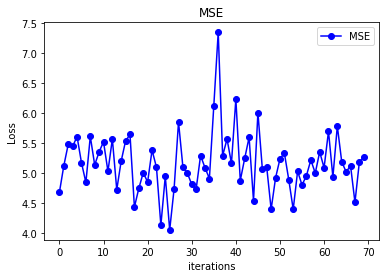

In [1049]:
plt.title("MSE")
plt.plot(MSE('/Users/eudari01/GNNs_Vs_CNNs/predictions/', '/Users/eudari01/GNNs_Vs_CNNs/CIN_log.csv', "CIN_log_0"), 'bo-',label="MSE")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig
plt.show()

In [1051]:
  #calcuate the global MSE
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true = y_true["CIN_log_0"], y_pred = y_pred)


9.831903887522527